In [5]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
import random
import os
import pickle
import time
import math
import copy
import pdb
from skimage import io

    100% |████████████████████████████████| 753.6MB 50.3MB/s 
fastai 1.0.51 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.


Load the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# directory path to store results/plots/models
dir_path = 'drive/My Drive/projet_asp'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Auxiliary functions

In [0]:
class SGD:

    def __init__(self, params, lr=0.5, momentum=0., weight_decay=0.0):
        """
        SGD with momentum for the inference part of
        training/testing. This speeds up training by using
        autograd.grad of the loss with respect to only the inputs
        but optimizer of pytorch is not compatible, so we make
        our own optimizer function
        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        self.lr = lr
        self.momentum = momentum
        self.v = torch.zeros_like(params)

    def update(self, gradients):
        self.v = self.momentum * self.v + self.lr * gradients
        return self.v

def show_img(img, black_and_white=True):
    np_img = img.cpu().numpy()
    # put channel at the end for plt.imshow
    if np_img.ndim == 3:
        np_img = np.transpose(np_img, (1, 2, 0))

    if black_and_white:
        plt.imshow(np_img, cmap='Greys_r')
        plt.show()
    else:
        plt.imshow(np_img)
        plt.show()


def save_img(img, path_to_save, black_and_white=True):
    np_img = img.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    if black_and_white:
        plt.imsave(path_to_save + ".jpg", np_img, cmap='Greys_r')
    else:
        plt.imsave(path_to_save + ".jpg", np_img)


def save_grid_imgs(input_imgs, path_to_save, black_and_white=True):
    img = utils.make_grid(input_imgs, nrow=8)
    save_img(img, path_to_save, black_and_white)
    
def show_grid_imgs(input_imgs, black_and_white=True):
    img = utils.make_grid(input_imgs, nrow=8)  
    show_img(img, black_and_white)


def plot_results(results, iou):
    """
    Parameters:
    ----------
    results: dictionary with the train/valid loss
    and the f1 scores]
    iou: bool
      if true: print IOU, else print F1 Score
    """
    str_score = 'IOU' if iou else 'F1 Score'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.set_title('Validation Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax2.set_title('Validation ' + str_score)
    ax2.set_ylabel(str_score)
    ax2.set_xlabel('epochs')

    ax1.plot(results['loss_train'], label='loss_train')
    ax1.plot(results['loss_valid'], label='loss_valid')
    if iou:
      ax2.plot(results['IOU_valid'])
    else:
      ax2.plot(results['f1_valid'])
      
    ax1.legend()
    plt.show()


Deep Value Network

In [0]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv1 = nn.Conv2d(4, 64, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, 2, padding=2)
        self.conv3 = nn.Conv2d(128, 128, 5, 2, padding=2)
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(128 * 6 * 6, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 1)
     
        # apply dropout on the first FC layer as paper mentioned
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x, y):
        # We first concatenate the img and the mask
        z = torch.cat((x, y), 1)
        
        z = F.relu(self.conv1(z))
        z = F.relu(self.conv2(z))
        z = F.relu(self.conv3(z))
                 
        # flatten before FC layers
        z = z.view(-1, 128 * 6 * 6)
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        z = F.relu(self.fc2(z))
        z = self.fc3(z)
        return z


class DeepValueNetwork:

    def __init__(self, dataset, dir_path, use_cuda, adversarial_sampling=True,
                 gt_sampling=False, stratified_sampling=False, batch_size=16, batch_size_eval=16,
                 learning_rate=0.01, inf_lr=50, momentum_inf=0, label_dim=(24, 24),
                 n_steps_inf=30, n_steps_inf_adversarial=1):
        """
        Parameters
        ----------
        use_cuda: boolean
            true if we are using gpu, false if using cpu
        learning_rate : float
            learning rate for updating the value network parameters
            default: 0.01 in DVN paper
        inf_lr : float
            learning rate for the inference procedure
        adversarial_sampling: bool
            Generate adversarial tuples while training.
            (Usually outperforms stratified sampling and adding ground truth)
        stratified_sampling: bool (Not yet implemented)
            Sample y proportional to its exponential oracle value.
            Sample from the exponentiated value distribution using stratified sampling.
        gt_sampling: bool
            Simply add the ground truth outputs y* with some probably p while training.
        """

        self.device = torch.device("cuda" if use_cuda else "cpu")

        self.adversarial_sampling = adversarial_sampling
        self.gt_sampling = gt_sampling
        self.stratified_sampling = stratified_sampling
        if self.stratified_sampling:
            raise ValueError('Stratified sampling is not yet implemented!')
        if self.gt_sampling and self.adversarial_sampling:
            raise ValueError('Adversarial examples and Adding Ground Truth are both set to true !')

        self.label_dim = label_dim

        # Inference hyperparameters
        self.n_steps_inf_adversarial = n_steps_inf_adversarial
        self.n_steps_inf = n_steps_inf
        self.inf_lr = inf_lr
        self.momentum_inf = momentum_inf
        self.new_ep = True
        ################################

        # for visualization purpose in "inference" function
        self.filename_train_other, self.filename_train_inf, self.filename_valid = 0, 0, 0
        # if directory doesn't exist, create it
        dir_predict_imgs = dir_path + '/pred/'
        self.dir_train_inf_img = dir_predict_imgs + '/train_inference/'
        self.dir_train_adversarial_img = dir_predict_imgs + '/train_adversarial/'
        self.dir_valid_img = dir_predict_imgs + '/valid/'
        for directory in [self.dir_train_inf_img, self.dir_train_adversarial_img, self.dir_valid_img]:
            if not os.path.isdir(directory):
                os.makedirs(directory)

        # Deep Value Network is just a ConvNet
        self.model = ConvNet().to(self.device)

        self.loss_fn = nn.BCEWithLogitsLoss()

        # Paper use SGD for convnet with learning rate = 0.01
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

        self.batch_size = batch_size
        self.batch_size_eval = batch_size_eval

        self.n_train = int(len(dataset) * 0.9)
        self.n_valid = len(dataset) - self.n_train
       

        print('Using a {} train {} validation split'.format(self.n_train, self.n_valid))
        indices = list(range(len(dataset)))
        random.shuffle(indices)

        self.train_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(indices[:self.n_train]),
            pin_memory=use_cuda
        )

        self.valid_loader = DataLoader(
            dataset,
            batch_size=batch_size_eval,
            sampler=SubsetRandomSampler(indices[self.n_train:]),
            pin_memory=use_cuda
        )

        # turn on/off
        self.training = False

    def get_oracle_value(self, pred_labels, gt_labels):
        """
        Compute the ground truth value, i.e. v*(y, y*)
        of some predicted labels, where v*(y, y*)
        is the relaxed version of the IOU (intersection
        over union) when training, and the discrete IOU
        when validating/testing
        """
        if pred_labels.shape != gt_labels.shape:
            raise ValueError('Invalid labels shape: gt = ', gt_labels.shape, 'pred = ', pred_labels.shape)

        if not self.training:
            # No relaxation, 0-1 only
            #pred_labels = torch.where(pred_labels >= 0.5,
            #                          torch.ones(1).to(self.device),
            #                          torch.zeros(1).to(self.device))
            pred_labels = pred_labels.float()

        pred_labels = torch.flatten(pred_labels).reshape(pred_labels.size()[0], -1)
        gt_labels = torch.flatten(gt_labels).reshape(gt_labels.size()[0], -1)

        intersect = torch.sum(torch.min(pred_labels, gt_labels), dim=1)
        union = torch.sum(torch.max(pred_labels, gt_labels), dim=1)

        # for numerical stability
        epsilon = torch.full(union.size(), 10 ** -8).to(self.device)
        
        iou = intersect / torch.max(epsilon, union)
        # we want a (Batch_size x 1) tensor
        iou = iou.view(-1, 1)
        return iou

    def get_ini_labels(self, x, gt_labels=None):
        """
        Get the tensor of predicted labels
        that we will do inference on
        """
        y = torch.zeros(x.size()[0], 1, self.label_dim[0], self.label_dim[1],
                        dtype=torch.float32, device=self.device)

        if gt_labels is not None:
            # 50% of initialization labels: Start from GT; rest: start from zeros
            gt_indices = torch.rand(gt_labels.shape[0]).float().to(self.device) > 0.5
            y[gt_indices] = gt_labels[gt_indices]

        # Set requires_grad=True after in_place operation (changing the indices)
        y.requires_grad = True
        return y

    def generate_output(self, x, gt_labels=None, ep=0):
        """
        Generate an output y to compute
        the loss v(y, y*) --> we can use different
        techniques to generate the output
        1) Gradient based inference
        2) Simply add the ground truth outputs
        2) Generating adversarial tuples
        3) TODO: Stratified Sampling: Random samples from Y, biased towards y*
        """

        if self.adversarial_sampling and self.training and np.random.rand() >= 0.5:
            # In training: Generate adversarial examples 50% of the time
            init_labels = self.get_ini_labels(x, gt_labels=gt_labels)
            #n_steps = random.randint(1, 5)
            pred_labels = self.inference(x, init_labels, self.n_steps_inf_adversarial,
                                         gt_labels=gt_labels, ep=ep)
        elif self.gt_sampling and self.training and np.random.rand() >= 0.5:
            # In training: If add_ground_truth=True, add ground truth outputs
            # to provide some positive examples to the network
            pred_labels = gt_labels
        else:
            init_labels = self.get_ini_labels(x)         
            n_steps = random.randint(1, self.n_steps_inf) if self.training else self.n_steps_inf
            pred_labels = self.inference(x, init_labels, n_steps, ep=ep)

        return pred_labels.detach().clone()

    def inference(self, x, y, num_iterations, gt_labels=None, ep=0):

        if self.training:
            self.model.eval()

        optim_inf = SGD(y, lr=self.inf_lr, momentum=self.momentum_inf)
                 
        hist_values = []
        reduced = 0
        # print condition to monitor progress
        print_cdn = ep % 10 == 0 and self.new_ep

        with torch.enable_grad():
            for i in range(num_iterations):
                                
                if gt_labels is not None:  # Adversarial                 
                    output = self.model(x, y)
                    oracle = self.get_oracle_value(y, gt_labels)
                    # this is the BCE loss with logits
                    value = self.loss_fn(output, oracle)
                    
                    if print_cdn and i == num_iterations - 1:
                      print('\n value = ', value, '(output, oracle) =', torch.cat((torch.sigmoid(output), oracle), 1))
                      img = x.detach().cpu()
                      show_grid_imgs(img)
                      
                      print('pred_mask =')
                      mask = y.detach().cpu()                                
                      show_grid_imgs(mask)
                      
                      print('real mask =')
                      real_mask = gt_labels.detach().cpu()
                      show_grid_imgs(real_mask)
                else:
                    output = self.model(x, y)
                    value = torch.sigmoid(output)
                   
                           
                grad = torch.autograd.grad(value, y, grad_outputs=torch.ones_like(value),
                                           only_inputs=True)
                                                
                y_grad = grad[0].detach()
                
                y = y + optim_inf.update(y_grad)
                # Project back to the valid range
                y = torch.clamp(y, 0, 1)
                
                # change learning rate if no progress
                value_np = np.mean(value.detach().cpu().numpy())
                hist_values.append(value_np)
                if len(hist_values) >= 3 and np.mean(hist_values[:-3]) >  value_np - 0.01 and np.mean(hist_values) > value_np - 0.01:
                    optim_inf.lr /= 2.5
                    reduced += 1                   
                    if print_cdn:
                        print("Reduced learning rate to {}: History = {}".format(optim_inf.lr, hist_values))
                    hist_values = []
                    if optim_inf.lr < 14.99 and reduced > 3:
                        if print_cdn:
                            print("Learning rate smaller than 1, we stop")
                        break
                                       
                if print_cdn:
                    if i == 4 or i == 9 or i == 14:
                        print('-----------INFERENCE(AFTER', i + 1 , 'steps)---------------')
                        img = x.detach().cpu()
                        show_grid_imgs(img[:8])

                        print('pred_mask  =')
                        mask = y.detach().cpu()                                
                        show_grid_imgs(mask[:8])
                    if i == num_iterations - 1:
                        img = y.detach().cpu()
                        if self.training:
                            if gt_labels is not None:
                                directory = self.dir_train_adversarial_img + str(self.filename_train_other)
                                self.filename_train_other += 1
                            else:                         
                                print('-----------INFERENCE---------------')
                                img = x.detach().cpu()
                                show_grid_imgs(img[:8])

                                print('pred_mask =')
                                mask = y.detach().cpu()                                
                                show_grid_imgs(mask[:8])
                                directory = self.dir_train_inf_img + str(self.filename_train_inf)
                                self.filename_train_inf += 1
                        else:
                            directory = self.dir_valid_img + str(self.filename_valid)
                            self.filename_valid += 1
                        save_grid_imgs(img, directory)
               
        if self.training:
            self.model.train()

        return y

    def train(self, ep):

        self.model.train()
        self.training = True

        time_start = time.time()
        t_loss, t_size = 0, 0

        for batch_idx, (inputs, targets) in enumerate(self.train_loader):

            inputs, targets = inputs.to(self.device), targets.to(self.device)
            inputs, targets = inputs.float(), targets.float()

            t_size += len(inputs)

            self.model.zero_grad()

            pred_labels = self.generate_output(inputs, targets, ep)         
            output = self.model(inputs, pred_labels)
            oracle = self.get_oracle_value(pred_labels, targets)

            loss = self.loss_fn(output, oracle)
            t_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            self.new_ep = False

            if batch_idx % 3 == 0:
                print('\rTraining Epoch {} [{} / {} ({:.0f}%)]: Time per epoch: {:.2f}s; '
                      'Avg_Loss = {:.5f}; Pred_IOU = {:.2f}%; Real_IOU = {:.2f}%'
                      ''.format(ep, t_size, self.n_train, 100 * t_size / self.n_train,
                                (self.n_train / t_size) * (time.time() - time_start), t_loss / t_size,
                                100 * torch.sigmoid(output).mean(), 100 * oracle.mean()),
                      end='')

        t_loss /= t_size
        self.training = False
        print('')
        return t_loss

    def valid(self, loader, test_set=False, ep=0):

        self.model.eval()
        self.training = False
        self.new_ep = True
        loss, t_size = 0, 0
        mean_iou = []

        with torch.no_grad():
            for (inputs, targets) in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                inputs, targets = inputs.float(), targets.float()
                t_size += len(inputs)

                pred_labels = self.generate_output(inputs, gt_labels=None, ep=ep)              
                output = self.model(inputs, pred_labels)
                oracle = self.get_oracle_value(pred_labels, targets)

                loss += self.loss_fn(output, oracle)
                mean_iou.append(oracle.mean())
                self.new_ep = False
                
        mean_iou = torch.stack(mean_iou)
        mean_iou = torch.mean(mean_iou)
        mean_iou = mean_iou.cpu().numpy()
        loss /= t_size

        str_first = 'Test set' if test_set else 'Validation set'
        print('{}: Loss = {:.5f}; Pred_IOU = {:.2f}%, Real_IOU = {:.2f}%'
              ''.format(str_first, loss.item(), 100 * torch.sigmoid(output).mean(), 100 * mean_iou))

        return loss.item(), mean_iou




Functions to run epoch and also to run hyperparameter search

In [0]:
def run_the_model(dataset, dir_path, use_cuda, save_model, batch_size, batch_size_eval,
                  n_epochs, adversarial_sampling=False, gt_sampling=False, stratified_sampling=False,
                  inf_lr=50, momentum_inf=0, n_steps_inf=30, n_steps_inf_adversarial=1,
                  step_size_scheduler_main=300, gamma_scheduler_main=1):

    DVN = DeepValueNetwork(dataset, dir_path, use_cuda,
                           adversarial_sampling=adversarial_sampling, gt_sampling=gt_sampling,
                           stratified_sampling=stratified_sampling, batch_size=batch_size, 
                           batch_size_eval=batch_size_eval, inf_lr=inf_lr,
                           momentum_inf=momentum_inf, n_steps_inf=n_steps_inf,
                           n_steps_inf_adversarial=n_steps_inf_adversarial)

    # Decay the learning rate by a factor of gamma every step_size # of epochs
    scheduler = torch.optim.lr_scheduler.StepLR(DVN.optimizer, step_size=step_size_scheduler_main,
                                                gamma=gamma_scheduler_main)

    results = {'name': 'DVN_Whorse', 'loss_train': [],
               'loss_valid': [], 'IOU_valid': [], 'batch_size': batch_size,
               'batch_size_eval': batch_size_eval,'adversarial_sampling': adversarial_sampling, 
               'gt_sampling': gt_sampling, 'stratified_sampling': stratified_sampling, 
               'inf_lr': inf_lr, 'n_steps_inf': n_steps_inf, 'momentum_inf': momentum_inf, 
               'step_size_scheduler_main': step_size_scheduler_main,
               'gamma_scheduler_main': gamma_scheduler_main, 'n_steps_inf_adversarial': n_steps_inf_adversarial}

    results_path = dir_path + '/results/'
    if not os.path.isdir(results_path):
        os.makedirs(results_path)

    # Increment a counter so that previous results with the same args will not
    # be overwritten. Comment out the next four lines if you only want to keep
    # the most recent results.
    i = 0
    while os.path.exists(results_path + str(i) + '.pkl'):
        i += 1
    results_path = results_path + str(i)

    stop_after_x = 25

    for epoch in range(n_epochs):
        loss_train = DVN.train(epoch)
        loss_valid, iou_valid = DVN.valid(DVN.valid_loader, ep=epoch)
        scheduler.step()
        results['loss_train'].append(loss_train)
        results['loss_valid'].append(loss_valid)
        results['IOU_valid'].append(iou_valid)

        with open(results_path + '.pkl', 'wb') as fout:
            pickle.dump(results, fout)
    
    plot_results(results, iou=True)
    
    if save_model:
        torch.save(DVN.model.state_dict(), results_path + '.pth')
        


Load dataset and choose to use cpu or gpu

In [13]:
# build the dataset, generate the "training tuple"
class WeizmannHorseDataset(Dataset):
    """ Weizmann Horse Dataset """
    
    def __init__(self, img_dir, mask_dir, test_set, do_normalize=False,
                 transform=None, random_mirroring=True):
        """
        Args:
            img_dir(string): Path to the image file (training image)
            mask_dir(string): Path to the mask file (segmentation result)
            test_set(bool): if we want test set or train set
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        all_img_names = os.listdir(img_dir)
        all_mask_names = os.listdir(mask_dir)

        self.img_names = []
        self.mask_names = []
        for i, name in enumerate(all_img_names):
            img_number = ''.join([n for n in name if n.isdigit()])
            if int(img_number) >= 200:
                if test_set:
                    self.img_names.append(name)
            else:
                self.img_names.append(name)
                
        for i, name in enumerate(all_mask_names):
            mask_number = ''.join([n for n in name if n.isdigit()]) 
            if int(mask_number) >= 200:
                if test_set:
                    self.mask_names.append(name)
            else:
                self.mask_names.append(name)
        
        
        self.img_names.sort()
        self.mask_names.sort()
        
        assert len(self.mask_names) == len(self.img_names)
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(size=(32, 32))])
        self.random_mirroring = random_mirroring
        self.operation_normalize = None
        self.do_normalize = do_normalize
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return len(self.img_names)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_names[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])
        
        image = io.imread(img_name)
        mask = io.imread(mask_name)

        if self.transform:
            image = self.transform(image)

            # create a channel for mask so as to transform
            mask = self.transform(np.expand_dims(mask, axis=2))

            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(24, 24))
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)
            
            # Random Horizontal flipping
            if self.random_mirroring and random.random() > 0.50:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            image, mask = self.to_tensor(image), self.to_tensor(mask)
            if self.do_normalize:
                image = self.operation_normalize(image)
            
            # put mask to 0-1 again
            mask = mask >= 0.5

        return image, mask

    def compute_mean_and_stddev(self):
        n_images = len(self.img_names)
        masks, images = [], []

        # ToTensor transforms the images/masks in range [0, 1]
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(size=(32, 32)),
                                        transforms.ToTensor()])

        for i in range(n_images):
            mask_name = os.path.join(self.mask_dir, self.mask_names[i])
            img_name = os.path.join(self.img_dir, self.img_names[i])
            mask = io.imread(mask_name)
            image = io.imread(img_name)
            
            
            image = transform(image)
            # create a channel for mask so as to transform
            mask = transform(np.expand_dims(mask, axis=2))
            
            #show_img(image, black_and_white=False)
            #show_img(mask.view(32, 32), black_and_white=True)
            masks.append(mask)
            images.append(image)

        # after torch.stack, we should have n_images x 1 x 32 x 32 for mask
        # and have n_images x 3 x 32 x 32 for images
        images, masks = torch.stack(images), torch.stack(masks)

        # compute mean and std_dev of images
        # put the images in n_images x 3 x (32x32) shape
        images = images.view(images.size(0), images.size(1), -1)
        mean_imgs = images.mean(2).sum(0) / n_images
        std_imgs = images.std(2).sum(0) / n_images
        ############################################

        # Find mean_mask for visualization purposes
        height, width = masks.shape[2], masks.shape[3]
        # flatten
        masks = masks.view(n_images, 1, -1)
        mean_mask = torch.mean(masks, dim=0)
        # go back to 32 x 32 view
        mean_mask = mean_mask.view(1, 1, height, width)

        print_mask = False
        if print_mask:
            img_to_show = mean_mask.squeeze(0)
            img_to_show = img_to_show.squeeze(0)
            show_img(img_to_show, black_and_white=True)

        return mean_imgs, std_imgs, mean_mask

# Use GPU if it is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
    
image_dir = dir_path + '/images'
mask_dir = dir_path + '/masks'

# Use Dataset to resize and convert to Tensor
WhorseDataset = WeizmannHorseDataset(image_dir, mask_dir, test_set=False, do_normalize=False,
                                     transform=None, random_mirroring=False)

mean_imgs, std_imgs, mean_mask = WhorseDataset.compute_mean_and_stddev()
print('mean_imgs =', mean_imgs, 'std_dev_imgs =', std_imgs)

WhorseDataset.normalize = transforms.Normalize(mean_imgs, std_imgs)

mean_imgs = tensor([0.5043, 0.4926, 0.4201]) std_dev_imgs = tensor([0.2076, 0.2104, 0.2074])


In [0]:
Run the model

Using a 180 train 20 validation split
Training Epoch 0 [5 / 180 (3%)]: Time per epoch: 1.53s; Avg_Loss = 0.13424; Pred_IOU = 51.11%; Real_IOU = 100.00%

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training Epoch 0 [170 / 180 (94%)]: Time per epoch: 1.94s; Avg_Loss = 0.13784; Pred_IOU = 52.16%; Real_IOU = 100.00%
Reduced learning rate to 60.0: History = [0.51839733, 0.51844436, 0.51849097, 0.51853627]
-----------INFERENCE(AFTER 5 steps)---------------


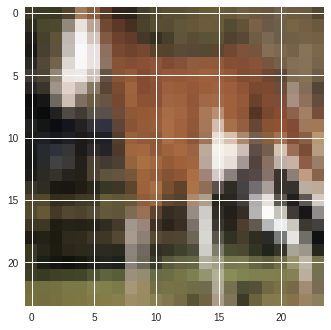

pred_mask  =


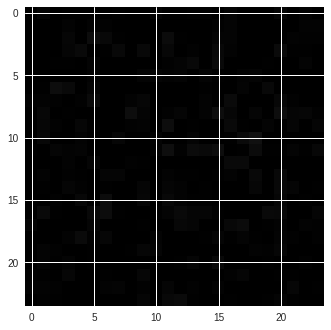

Reduced learning rate to 24.0: History = [0.5185803, 0.51859677, 0.5186136, 0.5186302]
-----------INFERENCE(AFTER 10 steps)---------------


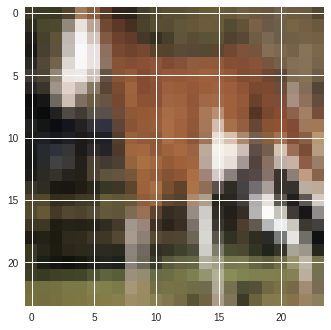

pred_mask  =


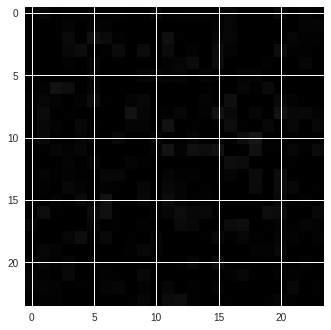

Reduced learning rate to 9.6: History = [0.5186469, 0.5186536, 0.5186602, 0.5186668]
-----------INFERENCE(AFTER 15 steps)---------------


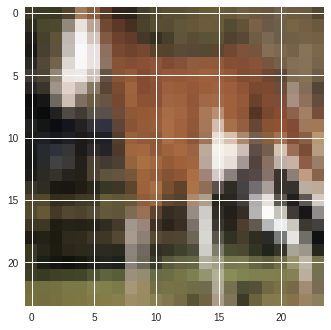

pred_mask  =


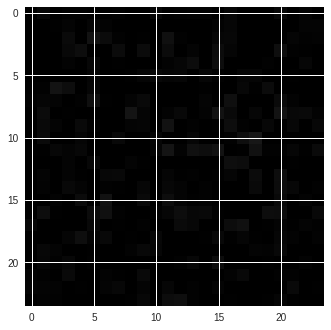

Reduced learning rate to 3.84: History = [0.5186734, 0.51867604, 0.51867867, 0.5186813]
Learning rate smaller than 1, we stop
Validation set: Loss = 0.72978; Pred_IOU = 51.85%, Real_IOU = 1.40%
Training Epoch 1 [170 / 180 (94%)]: Time per epoch: 1.61s; Avg_Loss = 0.13482; Pred_IOU = 54.02%; Real_IOU = 1.63%


KeyboardInterrupt: ignored

In [14]:
run_the_model(WhorseDataset, dir_path, use_cuda, save_model=False, 
              batch_size=5, batch_size_eval=1, n_epochs=500,
              adversarial_sampling=False, gt_sampling=True, stratified_sampling=False,
              inf_lr=150, momentum_inf=0, n_steps_inf=50, n_steps_inf_adversarial=1,
              step_size_scheduler_main=300, gamma_scheduler_main=0.10)
